<a href="https://colab.research.google.com/github/prat8897/DL_PyTorch/blob/master/Chapter6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Using a neural network to fit the data


## The PyTorch nn module

Let's start building a neural network from scratch with PyTorch. Our first step will be to replace our linear model with a neural network unit. This will be a somewhat useless step backward from a correctness perspective, since we’ve already verified that our calibration only required a linear function, but it will still be instrumental for starting on a sufficiently simple problem and scaling up later.

PyTorch has a whole submodule dedicated to neural networks, called `torch.nn`. It contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called modules in PyTorch parlance (such building blocks are often referred to as layers in other frameworks). A PyTorch module is a Python class deriving from the `nn.Module` base class. A module can have one or more Parameter instances as attributes, which are tensors whose values are optimized during the training process (think `w` and `b` in our linear model). A module can also have one or more submodules (subclasses of `nn.Module`) as attributes, and it will be able to track their parameters as well.


Unsurprisingly, we can find a subclass of `nn.Module` called `nn.Linear`, which applies an affine transformation to its input (via the parameter attributes weight and bias) and is equivalent to what we implemented earlier in our thermometer experiments. We’ll now start precisely where we left off and convert our previous code to a form that uses `nn`.


In our thermometer data, `t_u` and `t_c` were two 1D tensors of size B. Thanks to broadcasting, we could write our linear model as `w * x + b`, where `w` and `b` were two scalar parameters. This worked because we had a single input feature: if we had two, we would need to add an extra dimension to turn that 1D tensor into a matrix with samples in the rows and features in the columns.


### Batching Inputs
Any module in `nn` is written to produce outputs for a batch of multiple inputs at the same time. Thus, assuming we need to run `nn.Linear` on 10 samples, we can create an input tensor of size `B × Nin`, where `B` is the size of the batch and `Nin` is the number of input features, and run it once through the model.

That’s exactly what we need to do to switch to using `nn.Linear`. We reshape our `B` inputs to `B × Nin`, where `Nin` is `1`.

That is easily done with `unsqueeze`:

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) #adds extra dimension at axis 1
t_u = torch.tensor(t_u).unsqueeze(1) 

t_c, t_u

(tensor([[ 0.5000],
         [14.0000],
         [15.0000],
         [28.0000],
         [11.0000],
         [ 8.0000],
         [ 3.0000],
         [-4.0000],
         [ 6.0000],
         [13.0000],
         [21.0000]]), tensor([[35.7000],
         [55.9000],
         [58.2000],
         [81.9000],
         [56.3000],
         [48.9000],
         [33.9000],
         [21.8000],
         [48.4000],
         [60.4000],
         [68.4000]]))

Let's split our data into training and validation sets:

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

train_indices, val_indices

(tensor([ 8,  5,  1,  3, 10,  6,  0,  2,  4]), tensor([7, 9]))

And then normalize them: 

In [4]:
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

Let’s update our training code. First, we replace our handmade model with `nn.Linear(1,1)`, and then we need to pass the linear model parameters to the optimizer:

In [5]:
linear_model = nn.Linear(1, 1) #input size = 1, output size = 1, bias defaults to True
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

The arguments for `nn.Linear` refer to number of features. In this case it refers to the size of the input and the output tensor for the module, so 1 and 1.

If we used both temperature and barometric pressure as input, for instance, we would have two features in input and one feature in output. As we will see, for more complex models with several intermediate modules, the number of features will be associated with the capacity of the model.


We have an instance of `nn.Linear` with one input and one output feature. That only requires one weight and one bias:

In [7]:
linear_model(t_un_val)

tensor([[-0.9103],
        [-3.6124]], grad_fn=<AddmmBackward>)

In [8]:
linear_model.weight

Parameter containing:
tensor([[-0.7000]], requires_grad=True)

In [9]:
linear_model.bias

Parameter containing:
tensor([0.6157], requires_grad=True)

Earlier, it was our responsibility to create parameters and pass them as the first argument to `optim.SGD`. Now we can use the parameters method to ask any `nn.Module` for a list of parameters owned by it or any of its submodules:

In [6]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.7000]], requires_grad=True), Parameter containing:
 tensor([0.6157], requires_grad=True)]

This call recurses into submodules defined in the module’s `init` constructor and returns a flat list of all parameters encountered, so that we can conveniently pass it to the optimizer constructor as we did previously.

We can already figure out what happens in the training loop. The optimizer is provided with a list of tensors that were defined with `requires_grad = True` —all Parameters are defined this way by definition, since they need to be optimized by gradient descent. When `training_loss.backward()` is called, grad is accumulated on the leaf nodes of the graph, which are precisely the parameters that were passed to the optimizer.

At this point, the SGD optimizer has everything it needs. When `optimizer.step()` is called, it will iterate through each Parameter and change it by an amount proportional to what is stored in its grad attribute.

Let’s take a look a the training loop now:

In [71]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 200 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


It hasn’t changed practically at all, except that now we don’t pass `params` explicitly to model since the model itself holds its `parameters` internally.

There’s one last bit that we can leverage from `torch.nn`: the loss. Indeed, `nn` comes with several common loss functions, among them `nn.MSELoss` (MSE stands for Mean Square Error), which is exactly what we defined earlier as our `loss_fn`. Loss functions in `nn` are still subclasses of `nn.Module`, so we will create an instance and call it as a function. In our case, we get rid of the handwritten `loss_fn` and replace it:

In [12]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # using 'nn.MSELoss' instead of our handwritten 'loss_fn' function
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 127.4163, Validation loss 55.2923
Epoch 1000, Training loss 4.3918, Validation loss 2.5228
Epoch 2000, Training loss 2.6859, Validation loss 4.2292
Epoch 3000, Training loss 2.5444, Validation loss 5.7846

Parameter containing:
tensor([[5.6503]], requires_grad=True)
Parameter containing:
tensor([-18.7512], requires_grad=True)


We can compare this with our hand-written loss function:

In [13]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) 
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 116.7941, Validation loss 52.1141
Epoch 1000, Training loss 4.4677, Validation loss 2.5580
Epoch 2000, Training loss 2.6922, Validation loss 4.1921
Epoch 3000, Training loss 2.5449, Validation loss 5.7700

Parameter containing:
tensor([[5.6488]], requires_grad=True)
Parameter containing:
tensor([-18.7421], requires_grad=True)


Everything else input into our training loop stays the same. Even our results remain the same as before. Of course, getting the same results is expected, as a difference would imply a bug in one of the two implementations.

## Finally a neural network

There has been a lot to explore for these 20-something lines of code we require to define and train a model. Hopefully by now the magic involved in training has vanished and left room for the mechanics. What we learned so far will allow us to own the code we write instead of merely poking at a black box when things get more complicated.

There’s one last step left to take: replacing our linear model with a neural network as our approximating function. We said earlier that using a neural network will not result in a higher-quality model, since the process underlying our calibration problem was fundamentally linear. However, it’s good to make the leap from linear to neural network in a controlled environment so we won’t feel lost later.

### Replacing the linear model

We are going to keep everything else fixed, including the loss function, and only redefine model. Let’s build the simplest possible neural network: a linear module, followed by an activation function, feeding into another linear module. The first linear + activation layer is commonly referred to as a hidden layer for historical reasons, since its outputs are not observed directly but fed into the output layer. While the input and output of the model are both of size 1 (they have one input and one output feature), the size of the output of the first linear module is usually larger than 1. Recalling our earlier explanation of the role of activations, this can lead different units to respond to different ranges of the input, which increases the capacity of our model. The last linear layer will take the output of activations and combine them linearly to produce the output value.

`nn` provides a simple way to concatenate modules through the `nn.Sequential` container:

In [14]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # We chose 13 arbitrarilty
            nn.Tanh(),
            nn.Linear(13, 1)) # This 13 must match the first nn.Linear size
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

The end result is a model that takes the inputs expected by the first module specified as an argument of `nn.Sequential`, passes intermediate outputs to subsequent modules, and produces the output returned by the last module. The model fans out from 1 input feature to 13 hidden features, passes them through a `tanh` activation, and linearly combines the resulting 13 numbers into 1 output feature.

### Inspecting the parameters

Calling `model.parameters()` will collect weight and bias from both the first and second linear modules. It’s instructive to inspect the parameters in this case by printing their shapes:

In [15]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

These are the tensors that the optimizer will get. Again, after we call `model.backward()`, all parameters are populated with their grad, and the optimizer then updates their values accordingly during the `optimizer.step()` call. Not that different from our previous linear model. After all, they’re both differentiable models that can be trained using gradient descent.

A few notes on parameters of `nn.Modules`. When inspecting parameters of a model made up of several submodules, it is handy to be able to identify parameters by name. There’s a method for that, called `named_parameters`:


In [16]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


The name of each module in `Sequential` is just the ordinal with which the module appears in the arguments. Interestingly, `Sequential` also accepts an `OrderedDict`, in which we can name each module passed to `Sequential`:

In [17]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

This allows us to get more explanatory names for submodules:

In [18]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


This is more descriptive; but it does not give us more flexibility in the flow of data through the network, which remains a purely sequential pass-through—the `nn.Sequential` is very aptly named.

We can also access a particular `Parameter` by using submodules as attributes:

In [19]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.2312], requires_grad=True)

This is useful for inspecting parameters or their gradients: for instance, to monitor gradients during training, as we did at the beginning of this chapter. Say we want to print out the gradients of `weight` of the linear portion of the hidden layer. We can run the training loop for the new neural network model and then look at the resulting gradients after the last epoch:

In [20]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 225.5926, Validation loss 99.5733
Epoch 1000, Training loss 5.9963, Validation loss 4.0949
Epoch 2000, Training loss 4.0698, Validation loss 0.7043
Epoch 3000, Training loss 2.2201, Validation loss 1.7946
Epoch 4000, Training loss 1.8895, Validation loss 2.8877
Epoch 5000, Training loss 1.7467, Validation loss 3.8601
output tensor([[-2.0701],
        [16.5229]], grad_fn=<AddmmBackward>)
answer tensor([[-4.],
        [13.]])
hidden tensor([[  0.0876],
        [ 16.9464],
        [-15.4176],
        [ 15.3623],
        [ -6.5988],
        [ 12.7281],
        [ -0.1300],
        [  0.1504]])


## Comparing to the linear model

We can also evaluate the model on all of the data and see how it differs from a line:

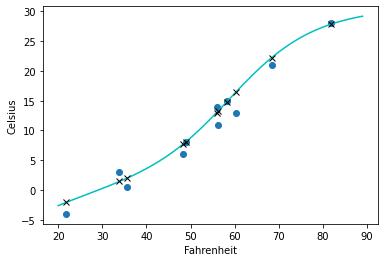

In [22]:
from matplotlib import pyplot as plt


def plot():
  t_range = torch.arange(20., 90.).unsqueeze(1)

  #fig = plt.figure(dpi=600)
  plt.xlabel("Fahrenheit")
  plt.ylabel("Celsius")
  plt.plot(t_u.numpy(), t_c.numpy(), 'o')
  plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
  plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

plot()

# Conclusion

We dissected building differentiable models and training them using gradient descent, first using raw `autograd` and then relying on `nn`. By now you should have confidence in your understanding of what’s going on behind the scenes.

# Exercises

1. Experiment with the number of hidden neurons in our simple neural network model, as well as the learning rate.

a. What changes result in more linear output from the model?

Increasing the number of hidden neurons results in a more linear output from the model.

Epoch 1, Training loss 216.2910, Validation loss 95.8322
Epoch 1000, Training loss 2.7702, Validation loss 5.4287
Epoch 2000, Training loss 2.2200, Validation loss 4.1335
Epoch 3000, Training loss 2.3960, Validation loss 2.2642
Epoch 4000, Training loss 2.2058, Validation loss 2.0102
Epoch 5000, Training loss 2.0546, Validation loss 2.0028


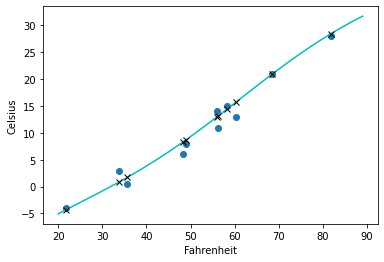

In [27]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 100)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(100, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
plot()

or, you can get a more linear output by using `LeakyRelu` instead of `Tanh`

Epoch 1, Training loss 164.0024, Validation loss 72.8315
Epoch 1000, Training loss 3.8056, Validation loss 2.5397
Epoch 2000, Training loss 2.2959, Validation loss 5.0475
Epoch 3000, Training loss 2.2483, Validation loss 4.9856
Epoch 4000, Training loss 2.1948, Validation loss 4.6934
Epoch 5000, Training loss 2.1366, Validation loss 4.3721


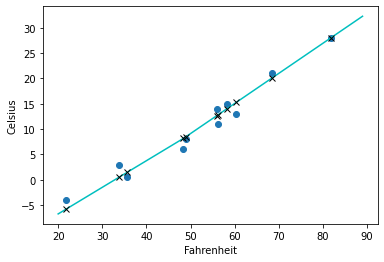

In [37]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.LeakyReLU()),
    ('output_linear', nn.Linear(8, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
plot()

b. Can you get the model to obviously overfit the data?

You can get the model to obviously overfit the data by increasing the number of layers/submodules in the neural network.

Epoch 1, Training loss 211.2102, Validation loss 93.6685
Epoch 1000, Training loss 26.1424, Validation loss 23.7577
Epoch 2000, Training loss 4.9504, Validation loss 11.5759
Epoch 3000, Training loss 3.9039, Validation loss 11.8518
Epoch 4000, Training loss 1.9410, Validation loss 11.9297
Epoch 5000, Training loss 1.4222, Validation loss 13.2829


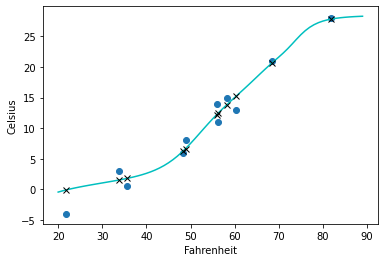

In [30]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 10)),
    ('hidden_activation', nn.Tanh()),
    ('hidden_linear_2', nn.Linear(10, 10)),
    ('hidden_activation_2', nn.Tanh()),
    ('hidden_linear_3', nn.Linear(10, 10)),
    ('hidden_activation_3', nn.Tanh()),
    ('output_linear', nn.Linear(10, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
plot()

or, by using `Hardtanh`

Epoch 1, Training loss 207.7009, Validation loss 92.5585
Epoch 1000, Training loss 6.2906, Validation loss 28.5730
Epoch 2000, Training loss 2.1190, Validation loss 27.8360
Epoch 3000, Training loss 5.2007, Validation loss 20.6244
Epoch 4000, Training loss 1.8503, Validation loss 20.6437
Epoch 5000, Training loss 1.5349, Validation loss 25.4582


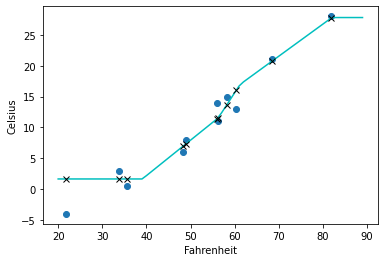

In [39]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Hardtanh()),
    ('output_linear', nn.Linear(8, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
plot()

2. The third-hardest problem in physics is finding a proper wine to celebrate discoveries. Load the wine data from chapter 4, and create a new model with the appropriate number of input parameters.

In [40]:
import csv
wine_path = "/content/winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",
                         skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [41]:
wineq = torch.from_numpy(wineq_numpy)

wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

In [61]:
data = wineq[:, :-1] #wine data without last quality label
target = wineq[:, -1].float() #quality label - the target

#target_onehot = torch.zeros(target.shape[0], 10)
#target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

target.unsqueeze_(1) 

data.shape, target.shape, target.dtype

(torch.Size([4898, 11]), torch.Size([4898, 1]), torch.float32)

Let's split our wine data into training and validation sets: 

In [63]:
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)#validation is 20% of the total set

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

data_train = data[train_indices]
target_train = target[train_indices]

data_val = data[val_indices]
target_val = target[val_indices]

data_train.shape, data_val.shape, target_train.shape, target_val.shape

(torch.Size([3919, 11]),
 torch.Size([979, 11]),
 torch.Size([3919, 1]),
 torch.Size([979, 1]))

There are 3919 samples with 11 features each. Therefore, our neural network needs 11 inputs.

In [73]:
wine_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(11, 20)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(20, 1))
]))

optimizer = optim.Adam(wine_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = wine_model,
    loss_fn = nn.MSELoss(),
    t_u_train = data_train,
    t_u_val = data_val, 
    t_c_train = target_train,
    t_c_val = target_val)


Epoch 1, Training loss 38.3504, Validation loss 38.2654
Epoch 200, Training loss 3.2920, Validation loss 3.2869
Epoch 400, Training loss 0.8727, Validation loss 0.8967
Epoch 600, Training loss 0.7498, Validation loss 0.7707
Epoch 800, Training loss 0.7206, Validation loss 0.7316
Epoch 1000, Training loss 0.6243, Validation loss 0.6318
Epoch 1200, Training loss 0.5882, Validation loss 0.5886
Epoch 1400, Training loss 0.5751, Validation loss 0.5767
Epoch 1600, Training loss 0.5654, Validation loss 0.5674
Epoch 1800, Training loss 0.5574, Validation loss 0.5537
Epoch 2000, Training loss 0.5461, Validation loss 0.5386
Epoch 2200, Training loss 0.5410, Validation loss 0.5335
Epoch 2400, Training loss 0.5374, Validation loss 0.5295
Epoch 2600, Training loss 0.5342, Validation loss 0.5262
Epoch 2800, Training loss 0.5312, Validation loss 0.5217
Epoch 3000, Training loss 0.5290, Validation loss 0.5250
Epoch 3200, Training loss 0.5275, Validation loss 0.5245
Epoch 3400, Training loss 0.5262, Va

# Summary

- Neural networks can be automatically adapted to specialize themselves on the problem at hand.
- Neural networks allow easy access to the analytical derivatives of the loss with respect to any parameter in the model, which makes evolving the parameters very efficient. Thanks to its automated differentiation engine, PyTorch provides such derivatives effortlessly.
- Activation functions around linear transformations make neural networks capable of approximating highly nonlinear functions, at the same time keeping them simple enough to optimize.
- The `nn` module together with the tensor standard library provide all the building blocks for creating neural networks.
- To recognize overfitting, it’s essential to maintain the training set of data points separate from the validation set. There’s no one recipe to combat overfitting, but getting more data, or more variability in the data, and resorting to simpler models are good starts.
- Anyone doing data science should be plotting data all the time.